In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-liar-dataset/data.csv


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import joblib

In [6]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "omarelmoujahid/the-liar-dataset",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

<ipython-input-6-bf07cbc98ce4>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:                                                title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text       subject  \
0  Donald Trump s White House is in chaos, and th...          News   
1  Now that Donald Trump is the presumptive GOP n...          News   
2  Mike Pence is a huge homophobe. He supports ex...          News   
3  SAN FRANCISCO (Reuters) - California Attorney ...  politicsNews   
4  Twisted reasoning is all that comes from Pelos...      politics   

               date  label  
0     July 21, 2017      0  
1       May 7, 2016      0  
2  December 3, 2016      0  
3  October 6, 2017       1  
4      Apr 25, 2017      0  


In [3]:
# ✅ 1. Load Data
df = pd.read_csv("/kaggle/input/the-liar-dataset/data.csv")

In [4]:
df.head()

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


In [5]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [6]:
df["full_text"] = df["title"] + " " + df["text"] + " " + df["subject"]  
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle data

In [7]:
df.head()

,title,text,subject,date,label,full_text
0,Yemen 'dismayed' by Trump's immigration order:...,(Reuters) - Yemen is “dismayed” by U.S. Presid...,politicsNews,"January 28, 2017",1,Yemen 'dismayed' by Trump's immigration order:...
1,"Trump dismays, angers allies by abandoning glo...",WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"May 31, 2017",1,"Trump dismays, angers allies by abandoning glo..."
2,The Top Ten Reasons We NEED A Liberal Supreme...,"One way or another, the passing of Supreme Cou...",News,"February 14, 2016",0,The Top Ten Reasons We NEED A Liberal Supreme...
3,Colombia and ELN rebels begin first-ever cease...,BOGOTA (Reuters) - Colombia and the Marxist EL...,worldnews,"October 1, 2017",1,Colombia and ELN rebels begin first-ever cease...
4,Fears of dam collapse add to Puerto Rico's mis...,"SAN JUAN, Puerto Rico (Reuters) - Puerto Rico ...",worldnews,"September 23, 2017",1,Fears of dam collapse add to Puerto Rico's mis...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   label      44898 non-null  int64 
 5   full_text  44898 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [9]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["full_text"].values, df["label"].values, test_size=0.2, random_state=42
)

In [10]:
 ##Load SBERT Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
print("i m using " ,device)

i m using  cuda


In [12]:
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
#Generate SBERT Embeddings
def get_sbert_embeddings(texts, model):
    return model.encode(texts, convert_to_numpy=True)

X_train = get_sbert_embeddings(train_texts, sbert_model)
X_test = get_sbert_embeddings(test_texts, sbert_model)

y_train = np.array(train_labels)
y_test = np.array(test_labels)


Batches:   0%|          | 0/1123 [00:00<?, ?it/s]

Batches:   0%|          | 0/281 [00:00<?, ?it/s]

In [14]:
#Create Dataset and DataLoader
class TheDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [16]:
train_dataset = TheDataset(X_train, y_train)
test_dataset = TheDataset(X_test, y_test)

In [17]:
train_dataset

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
class SBERTClassifier(nn.Module):
    def __init__(self, embedding_dim=384, num_classes=2, use_softmax=True):
        super(SBERTClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
        self.softmax = nn.Softmax(dim=1) if use_softmax else nn.Identity()  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

In [29]:
# class SBERTClassifier(nn.Module):
#     def __init__(self, embedding_dim=384, num_classes=2, dropout_rate=0.2,use_softmax=True):
#         super(SBERTClassifier, self).__init__()
#         self.classifier = nn.Sequential(
#         nn.Linear(embedding_dim, 256),
#         nn.ReLU(),
#         nn.Dropout(dropout_rate),
#         nn.Linear(256, 128),
#         nn.ReLU(),
#         nn.Dropout(dropout_rate),
#         nn.Linear(128, num_classes),
#     )
        
#     def forward(self, embeddings):
#         return self.classifier(embeddings)

In [30]:
# class SBERTClassifier(nn.Module):
#     def __init__(self, embedding_dim=384, num_classes=2, dropout_rate=0.2, use_softmax=True):
#         super(SBERTClassifier, self).__init__()
        
#         layers = [
#             nn.Linear(embedding_dim, 256),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(128, num_classes)  
#         ]
        
#         if use_softmax:
#             layers.append(nn.Softmax(dim=1))  

#         self.classifier = nn.Sequential(*layers)

#     def forward(self, embeddings):
#         return self.classifier(embeddings)

In [43]:
#  Train Model
def train_model(model, train_loader, test_loader, epochs=10, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # Evaluate on test set
        model.eval()
        test_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(y_batch.cpu().numpy())

        test_losses.append(test_loss / len(test_loader))
        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Test Loss={test_losses[-1]:.4f}, Accuracy={accuracy:.4f}")

    return model, train_losses, test_losses

In [44]:
model_softmax = SBERTClassifier(use_softmax=True)

In [35]:
print("\nTraining with Softmax...")
model_softmax_10, train_losses_softmax_10, test_losses_softmax_10 = train_model(model_softmax, train_loader, test_loader,epochs=10)
print("\nTraining with Softmax...")
model_softmax_20, train_losses_softmax_20, test_losses_softmax_20 = train_model(model_softmax, train_loader, test_loader,epochs=20)


Training with Softmax...


Epoch 1/10: 100%|██████████| 1123/1123 [00:02<00:00, 552.32it/s]


Epoch 1: Train Loss=0.3262, Test Loss=0.3454, Accuracy=0.9666


Epoch 2/10: 100%|██████████| 1123/1123 [00:02<00:00, 551.40it/s]


Epoch 2: Train Loss=0.3271, Test Loss=0.3433, Accuracy=0.9693


Epoch 3/10: 100%|██████████| 1123/1123 [00:02<00:00, 539.16it/s]


Epoch 3: Train Loss=0.3269, Test Loss=0.3422, Accuracy=0.9705


Epoch 4/10: 100%|██████████| 1123/1123 [00:02<00:00, 555.29it/s]


Epoch 4: Train Loss=0.3262, Test Loss=0.3429, Accuracy=0.9696


Epoch 5/10: 100%|██████████| 1123/1123 [00:02<00:00, 555.11it/s]


Epoch 5: Train Loss=0.3248, Test Loss=0.3415, Accuracy=0.9714


Epoch 6/10: 100%|██████████| 1123/1123 [00:02<00:00, 553.39it/s]


Epoch 6: Train Loss=0.3252, Test Loss=0.3430, Accuracy=0.9692


Epoch 7/10: 100%|██████████| 1123/1123 [00:02<00:00, 520.21it/s]


Epoch 7: Train Loss=0.3257, Test Loss=0.3429, Accuracy=0.9700


Epoch 8/10: 100%|██████████| 1123/1123 [00:02<00:00, 546.19it/s]


Epoch 8: Train Loss=0.3250, Test Loss=0.3455, Accuracy=0.9669


Epoch 9/10: 100%|██████████| 1123/1123 [00:02<00:00, 543.45it/s]


Epoch 9: Train Loss=0.3245, Test Loss=0.3435, Accuracy=0.9692


Epoch 10/10: 100%|██████████| 1123/1123 [00:02<00:00, 539.51it/s]


Epoch 10: Train Loss=0.3250, Test Loss=0.3431, Accuracy=0.9698

Training with Softmax...


Epoch 1/20: 100%|██████████| 1123/1123 [00:02<00:00, 553.57it/s]


Epoch 1: Train Loss=0.3238, Test Loss=0.3420, Accuracy=0.9712


Epoch 2/20: 100%|██████████| 1123/1123 [00:02<00:00, 542.99it/s]


Epoch 2: Train Loss=0.3241, Test Loss=0.3431, Accuracy=0.9697


Epoch 3/20: 100%|██████████| 1123/1123 [00:02<00:00, 551.23it/s]


Epoch 3: Train Loss=0.3245, Test Loss=0.3412, Accuracy=0.9714


Epoch 4/20: 100%|██████████| 1123/1123 [00:02<00:00, 547.89it/s]


Epoch 4: Train Loss=0.3242, Test Loss=0.3415, Accuracy=0.9713


Epoch 5/20: 100%|██████████| 1123/1123 [00:02<00:00, 539.57it/s]


Epoch 5: Train Loss=0.3245, Test Loss=0.3414, Accuracy=0.9712


Epoch 6/20: 100%|██████████| 1123/1123 [00:02<00:00, 542.45it/s]


Epoch 6: Train Loss=0.3239, Test Loss=0.3418, Accuracy=0.9706


Epoch 7/20: 100%|██████████| 1123/1123 [00:02<00:00, 559.30it/s]


Epoch 7: Train Loss=0.3240, Test Loss=0.3424, Accuracy=0.9704


Epoch 8/20: 100%|██████████| 1123/1123 [00:01<00:00, 562.43it/s]


Epoch 8: Train Loss=0.3250, Test Loss=0.3401, Accuracy=0.9725


Epoch 9/20: 100%|██████████| 1123/1123 [00:02<00:00, 546.84it/s]


Epoch 9: Train Loss=0.3234, Test Loss=0.3448, Accuracy=0.9678


Epoch 10/20: 100%|██████████| 1123/1123 [00:02<00:00, 555.85it/s]


Epoch 10: Train Loss=0.3227, Test Loss=0.3420, Accuracy=0.9709


Epoch 11/20: 100%|██████████| 1123/1123 [00:02<00:00, 516.70it/s]


Epoch 11: Train Loss=0.3232, Test Loss=0.3413, Accuracy=0.9717


Epoch 12/20: 100%|██████████| 1123/1123 [00:02<00:00, 549.88it/s]


Epoch 12: Train Loss=0.3239, Test Loss=0.3420, Accuracy=0.9713


Epoch 13/20: 100%|██████████| 1123/1123 [00:02<00:00, 543.09it/s]


Epoch 13: Train Loss=0.3229, Test Loss=0.3411, Accuracy=0.9716


Epoch 14/20: 100%|██████████| 1123/1123 [00:01<00:00, 561.62it/s]


Epoch 14: Train Loss=0.3222, Test Loss=0.3397, Accuracy=0.9729


Epoch 15/20: 100%|██████████| 1123/1123 [00:02<00:00, 539.73it/s]


Epoch 15: Train Loss=0.3221, Test Loss=0.3401, Accuracy=0.9724


Epoch 16/20: 100%|██████████| 1123/1123 [00:02<00:00, 554.12it/s]


Epoch 16: Train Loss=0.3230, Test Loss=0.3406, Accuracy=0.9724


Epoch 17/20: 100%|██████████| 1123/1123 [00:02<00:00, 542.88it/s]


Epoch 17: Train Loss=0.3225, Test Loss=0.3425, Accuracy=0.9700


Epoch 18/20: 100%|██████████| 1123/1123 [00:01<00:00, 563.03it/s]


Epoch 18: Train Loss=0.3229, Test Loss=0.3416, Accuracy=0.9714


Epoch 19/20: 100%|██████████| 1123/1123 [00:02<00:00, 542.31it/s]


Epoch 19: Train Loss=0.3232, Test Loss=0.3392, Accuracy=0.9742


Epoch 20/20: 100%|██████████| 1123/1123 [00:02<00:00, 552.65it/s]


Epoch 20: Train Loss=0.3226, Test Loss=0.3420, Accuracy=0.9708


In [36]:
# Save the Model
torch.save(model_softmax_10.state_dict(), "sbert_classifier_softmax.pth")
torch.save(model_softmax_20.state_dict(), "sbert_classifier_softmax.pth")
joblib.dump(sbert_model, "sbert_model.pkl")

['sbert_model.pkl']

In [37]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


Evaluation with Softmax whit 10 epoch:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4658
           1       0.96      0.98      0.97      4322

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



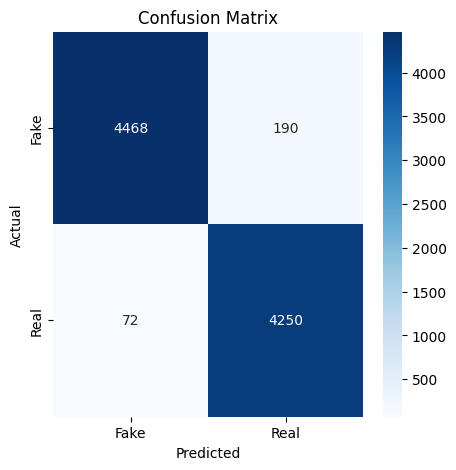


Evaluation without Softmax with 20 epoch:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4658
           1       0.96      0.98      0.97      4322

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



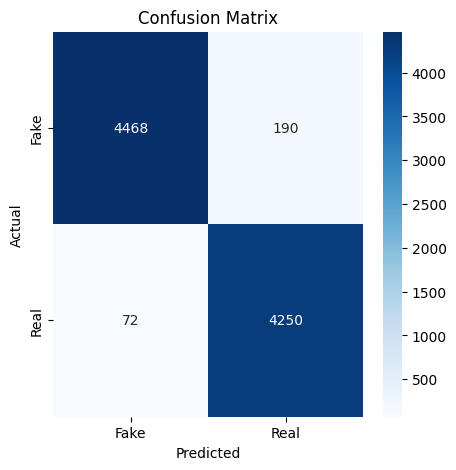

In [39]:
# Evaluate and plot
print("\nEvaluation with Softmax whit 10 epoch:")
evaluate_model(model_softmax_10, test_loader)

print("\nEvaluation without Softmax with 20 epoch:")
evaluate_model(model_softmax_20, test_loader)

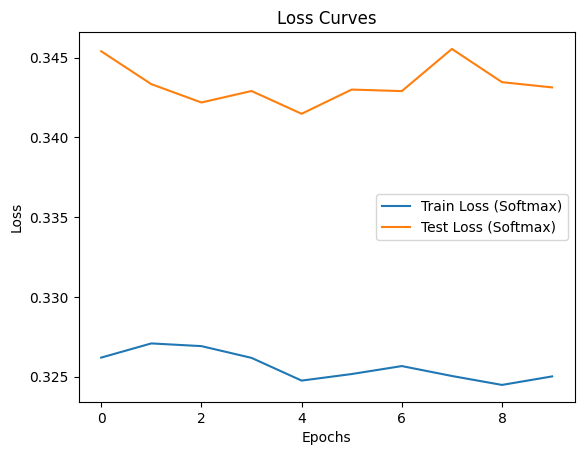

In [40]:
#Plot Training Loss Curves
plt.plot(train_losses_softmax_10, label="Train Loss (Softmax)")
plt.plot(test_losses_softmax_10, label="Test Loss (Softmax)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

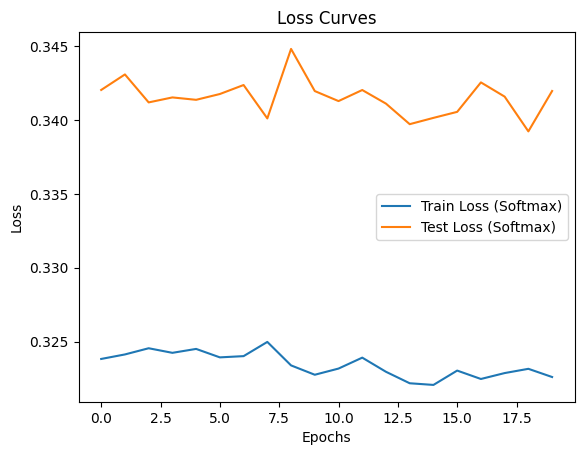

In [41]:
#Plot Training Loss Curves
plt.plot(train_losses_softmax_20, label="Train Loss (Softmax)")
plt.plot(test_losses_softmax_20, label="Test Loss (Softmax)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()


Training with Softmax...


Epoch 1/10: 100%|██████████| 1123/1123 [00:01<00:00, 655.89it/s]


Epoch 1: Train Loss=0.3911, Test Loss=0.3682, Accuracy=0.9441


Epoch 2/10: 100%|██████████| 1123/1123 [00:01<00:00, 656.17it/s]


Epoch 2: Train Loss=0.3604, Test Loss=0.3606, Accuracy=0.9503


Epoch 3/10: 100%|██████████| 1123/1123 [00:01<00:00, 662.51it/s]


Epoch 3: Train Loss=0.3550, Test Loss=0.3589, Accuracy=0.9530


Epoch 4/10: 100%|██████████| 1123/1123 [00:01<00:00, 668.78it/s]


Epoch 4: Train Loss=0.3514, Test Loss=0.3553, Accuracy=0.9558


Epoch 5/10: 100%|██████████| 1123/1123 [00:01<00:00, 645.77it/s]


Epoch 5: Train Loss=0.3492, Test Loss=0.3548, Accuracy=0.9563


Epoch 6/10: 100%|██████████| 1123/1123 [00:01<00:00, 656.10it/s]


Epoch 6: Train Loss=0.3464, Test Loss=0.3534, Accuracy=0.9586


Epoch 7/10: 100%|██████████| 1123/1123 [00:01<00:00, 661.79it/s]


Epoch 7: Train Loss=0.3437, Test Loss=0.3507, Accuracy=0.9606


Epoch 8/10: 100%|██████████| 1123/1123 [00:01<00:00, 649.55it/s]


Epoch 8: Train Loss=0.3407, Test Loss=0.3552, Accuracy=0.9571


Epoch 9/10: 100%|██████████| 1123/1123 [00:01<00:00, 671.67it/s]


Epoch 9: Train Loss=0.3381, Test Loss=0.3465, Accuracy=0.9654


Epoch 10/10: 100%|██████████| 1123/1123 [00:01<00:00, 663.06it/s]


Epoch 10: Train Loss=0.3360, Test Loss=0.3454, Accuracy=0.9653

Training without Softmax (Logits)...


Epoch 1/10: 100%|██████████| 1123/1123 [00:01<00:00, 665.73it/s]


Epoch 1: Train Loss=0.1703, Test Loss=0.1271, Accuracy=0.9512


Epoch 2/10: 100%|██████████| 1123/1123 [00:01<00:00, 658.20it/s]


Epoch 2: Train Loss=0.1116, Test Loss=0.1088, Accuracy=0.9557


Epoch 3/10: 100%|██████████| 1123/1123 [00:01<00:00, 663.04it/s]


Epoch 3: Train Loss=0.0985, Test Loss=0.1019, Accuracy=0.9579


Epoch 4/10: 100%|██████████| 1123/1123 [00:01<00:00, 661.03it/s]


Epoch 4: Train Loss=0.0868, Test Loss=0.0979, Accuracy=0.9611


Epoch 5/10: 100%|██████████| 1123/1123 [00:01<00:00, 663.45it/s]


Epoch 5: Train Loss=0.0759, Test Loss=0.0928, Accuracy=0.9644


Epoch 6/10: 100%|██████████| 1123/1123 [00:01<00:00, 678.11it/s]


Epoch 6: Train Loss=0.0645, Test Loss=0.0824, Accuracy=0.9674


Epoch 7/10: 100%|██████████| 1123/1123 [00:01<00:00, 684.22it/s]


Epoch 7: Train Loss=0.0544, Test Loss=0.0765, Accuracy=0.9707


Epoch 8/10: 100%|██████████| 1123/1123 [00:01<00:00, 693.29it/s]


Epoch 8: Train Loss=0.0454, Test Loss=0.0767, Accuracy=0.9719


Epoch 9/10: 100%|██████████| 1123/1123 [00:01<00:00, 703.44it/s]


Epoch 9: Train Loss=0.0393, Test Loss=0.0761, Accuracy=0.9724


Epoch 10/10: 100%|██████████| 1123/1123 [00:01<00:00, 683.26it/s]


Epoch 10: Train Loss=0.0318, Test Loss=0.0721, Accuracy=0.9747

Evaluation with Softmax:

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4658
           1       0.96      0.97      0.96      4322

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



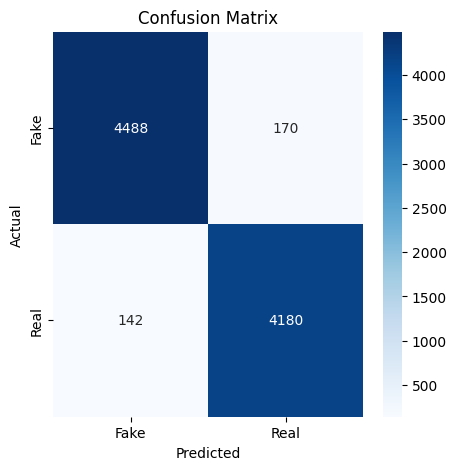


Evaluation without Softmax:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4658
           1       0.97      0.98      0.97      4322

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



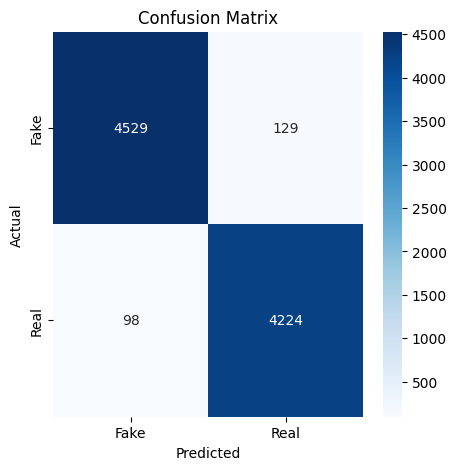

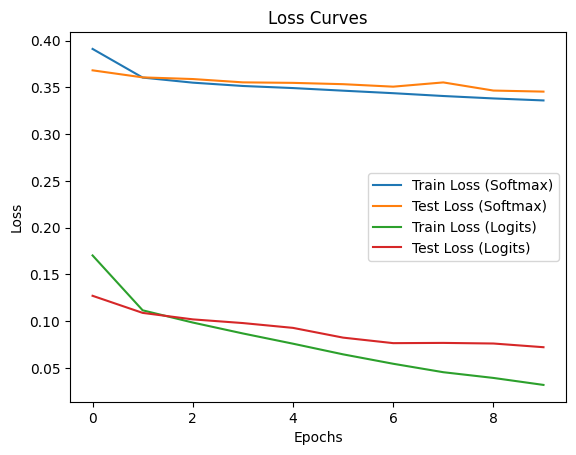

In [46]:
model_softmax = SBERTClassifier(use_softmax=True)
print("\nTraining with Softmax...")
model_softmax, train_losses_softmax, test_losses_softmax = train_model(model_softmax, train_loader, test_loader)
model_logits= SBERTClassifier(use_softmax=False)
print("\nTraining without Softmax (Logits)...")
model_logits, train_losses_logits, test_losses_logits = train_model(model_logits, train_loader, test_loader)

#  Save the Model
torch.save(model_softmax.state_dict(), "sbert_classifier_softmax.pth")
torch.save(model_logits.state_dict(), "sbert_classifier_logits.pth")
joblib.dump(sbert_model, "sbert_model.pkl")
#  Evaluate and plot
print("\nEvaluation with Softmax:")
evaluate_model(model_softmax, test_loader)

print("\nEvaluation without Softmax:")
evaluate_model(model_logits, test_loader)

# Plot Training Loss Curves
plt.plot(train_losses_softmax, label="Train Loss (Softmax)")
plt.plot(test_losses_softmax, label="Test Loss (Softmax)")
plt.plot(train_losses_logits, label="Train Loss (Logits)")
plt.plot(test_losses_logits, label="Test Loss (Logits)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

In [49]:
custom_texts = [
        # True news examples
        ("Recent scientific research has confirmed that regular exercise improves cardiovascular health and reduces the risk of chronic diseases.", "True"),
        ("The national weather service has issued a hurricane warning for coastal areas as the storm approaches.", "True News"),
        ("The government announced a new infrastructure plan that will invest in roads, bridges, and public transportation over the next decade.", "True"),
        ("According to the latest economic report, unemployment rates have decreased by 0.5% in the last quarter.", "True"),
        ("Scientists have discovered a new species of deep-sea creatures during an oceanographic expedition.", "True"),
        
        # Fake news examples
        ("Scientists discover that drinking coffee mixed with lemon juice can cure all types of cancer within 24 hours.", "Fake"),
        ("Government secretly installing mind control devices in all new smartphones to monitor citizens' thoughts.", "Fake"),
        ("New study proves that the earth is actually flat and all space images are computer-generated by NASA.", "Fake"),
        ("Experts reveal that dinosaurs never existed and all fossils were planted by a secret organization.", "Fake"),
        ("Breaking: Celebrity found to be an alien from another galaxy according to leaked government documents.", "Fake")
    ]

In [50]:
for text , label in custom_texts:
    label=1 if label=="True" else 0 
    print(f"text {text} , label {label}")

text Recent scientific research has confirmed that regular exercise improves cardiovascular health and reduces the risk of chronic diseases. , label 1
text The national weather service has issued a hurricane warning for coastal areas as the storm approaches. , label 0
text The government announced a new infrastructure plan that will invest in roads, bridges, and public transportation over the next decade. , label 1
text According to the latest economic report, unemployment rates have decreased by 0.5% in the last quarter. , label 1
text Scientists have discovered a new species of deep-sea creatures during an oceanographic expedition. , label 1
text Scientists discover that drinking coffee mixed with lemon juice can cure all types of cancer within 24 hours. , label 0
text Government secretly installing mind control devices in all new smartphones to monitor citizens' thoughts. , label 0
text New study proves that the earth is actually flat and all space images are computer-generated by N

In [73]:
def test_news_classifier(test_texts, model_clas, model_tokenization):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_clas = model_clas.to(device)
    
    true_labels = []
    predicted_labels = []
    
    for text, label in test_texts:
        label = 1 if label == "True" else 0 
        # Get embedding using tokenizer
        with torch.no_grad():
            inputs = model_tokenization.encode([text], convert_to_tensor=True).to(device)  
            # Get model prediction
            # inputs = torch.tensor(inputs, dtype=torch.float32)
            logits = model_clas(inputs)
            prediction = torch.argmax(logits, dim=1).cpu().item() 
        
        true_labels.append(label)
        predicted_labels.append(prediction)

        print(f"Text: {text[:100]}...\nTrue Label: {label}\nPrediction: {prediction}\n")
    
    # Calculate Accuracy
    accuracy = accuracy_score(true_labels, predicted_labels) * 100
    print(f"\n✅ Model Accuracy on Test Set: {accuracy:.2f}%")

    # Generate classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

In [74]:
test_news_classifier(custom_texts,model_logits,sbert_model)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: Recent scientific research has confirmed that regular exercise improves cardiovascular health and re...
True Label: 1
Prediction: 1



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: The national weather service has issued a hurricane warning for coastal areas as the storm approache...
True Label: 0
Prediction: 1



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: The government announced a new infrastructure plan that will invest in roads, bridges, and public tr...
True Label: 1
Prediction: 1



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: According to the latest economic report, unemployment rates have decreased by 0.5% in the last quart...
True Label: 1
Prediction: 0



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: Scientists have discovered a new species of deep-sea creatures during an oceanographic expedition....
True Label: 1
Prediction: 1



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: Scientists discover that drinking coffee mixed with lemon juice can cure all types of cancer within ...
True Label: 0
Prediction: 0



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: Government secretly installing mind control devices in all new smartphones to monitor citizens' thou...
True Label: 0
Prediction: 0



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: New study proves that the earth is actually flat and all space images are computer-generated by NASA...
True Label: 0
Prediction: 0



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: Experts reveal that dinosaurs never existed and all fossils were planted by a secret organization....
True Label: 0
Prediction: 0



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: Breaking: Celebrity found to be an alien from another galaxy according to leaked government document...
True Label: 0
Prediction: 0


✅ Model Accuracy on Test Set: 80.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.75      0.75      0.75         4

    accuracy                           0.80        10
   macro avg       0.79      0.79      0.79        10
weighted avg       0.80      0.80      0.80        10

